In [1]:
import sys
 
sys.path.insert(0, "../")

from EnsembleFramework import Framework

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

dataset_name = 'Cora'
split = "public"
dataset = Planetoid(root='/tmp/Cora', name=dataset_name, split=split)
dataset.transform = T.NormalizeFeatures()

features =  dataset[0].x
y =  dataset[0].y

test =  dataset[0].test_mask
train = dataset[0].train_mask
val =  dataset[0].val_mask

edge_index = dataset[0].edge_index 
edge_index = add_self_loops(edge_index)[0]

In [3]:
import pandas as pd
import ast

hops_to_best_params_df = pd.read_csv("normalized_origin_features_plus_summed_neighbors_wo_attn.csv")
evaluated_hops = hops_to_best_params_df.iloc[:,0].values
best_params = hops_to_best_params_df.iloc[:,1].values
hops_to_best_params = dict({hop: ast.literal_eval(best_params[i]) for i, hop in enumerate(evaluated_hops)})
hops_to_best_params

{0: {'max_depth': 10,
  'max_leaf_nodes': 100,
  'max_samples': 0.7127048350614942,
  'min_samples_leaf': 0.0007347195450014008,
  'n_estimators': 1200},
 1: {'max_depth': 8,
  'max_leaf_nodes': 50,
  'max_samples': 0.7198121330672383,
  'min_samples_leaf': 0.014945954643571437,
  'n_estimators': 1200},
 2: {'max_depth': None,
  'max_leaf_nodes': 50,
  'max_samples': 0.7553537798942114,
  'min_samples_leaf': 0.0017593872755720177,
  'n_estimators': 400},
 3: {'max_depth': None,
  'max_leaf_nodes': None,
  'max_samples': 0.7002439046806193,
  'min_samples_leaf': 0.0003500250283292052,
  'n_estimators': 50},
 4: {'max_depth': None,
  'max_leaf_nodes': None,
  'max_samples': 0.6113456854172565,
  'min_samples_leaf': 0.00013560095683622664,
  'n_estimators': 100},
 5: {'max_depth': 10,
  'max_leaf_nodes': 200,
  'max_samples': 0.7256981607470887,
  'min_samples_leaf': 0.01838066829670684,
  'n_estimators': 800},
 6: {'max_depth': 8,
  'max_leaf_nodes': 200,
  'max_samples': 0.7462052907435

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(scores):
    node_labels = y.cpu().numpy()
    num_classes = len(set(node_labels))
    
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(scores)
    
    fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}
    for class_id in range(num_classes):
        
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
    plt.show()

XGBoost with [0] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.594; Test acc 0.612
The required training time was 1.44 s


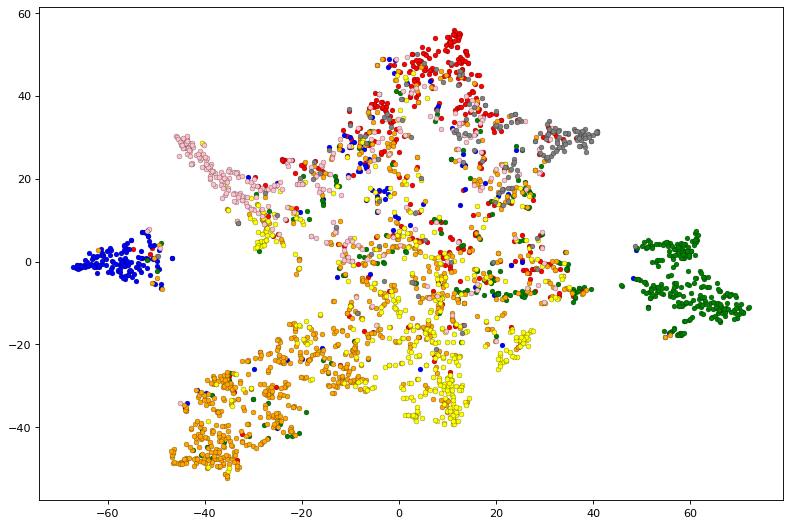

XGBoost with [1] hops has the following accuracies:
Train acc: 0.9785714285714285; Val acc 0.8; Test acc 0.797
The required training time was 2.65 s


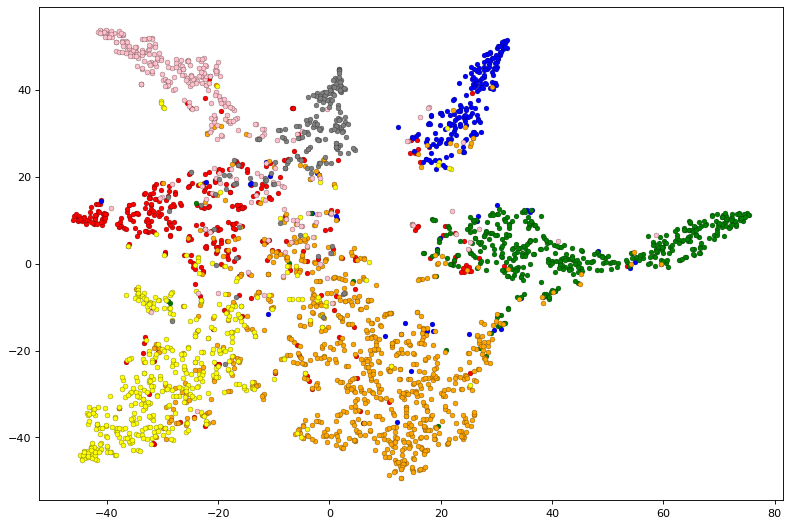

XGBoost with [2] hops has the following accuracies:
Train acc: 1.0; Val acc 0.804; Test acc 0.788
The required training time was 2.86 s


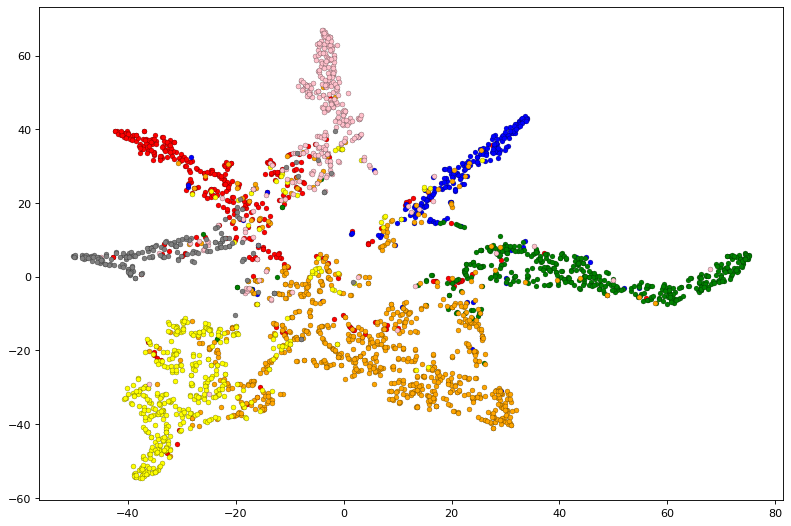

XGBoost with [3] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.766; Test acc 0.725
The required training time was 3.59 s


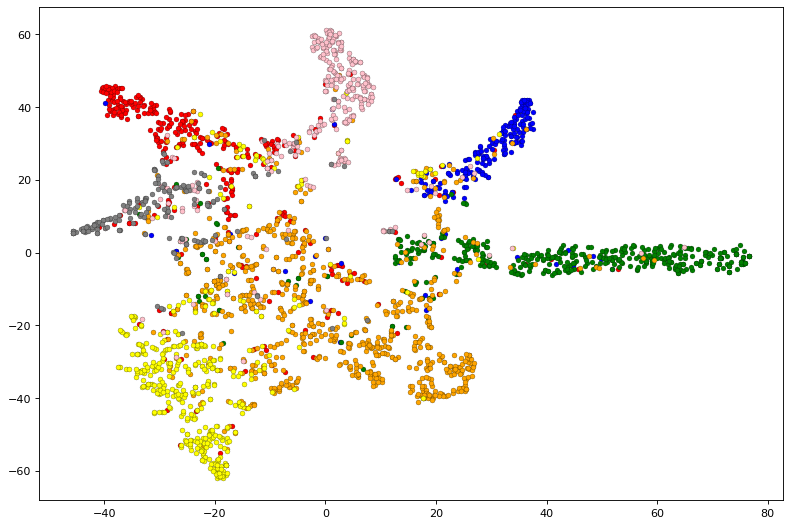

XGBoost with [4] hops has the following accuracies:
Train acc: 0.9928571428571429; Val acc 0.768; Test acc 0.739
The required training time was 4.85 s


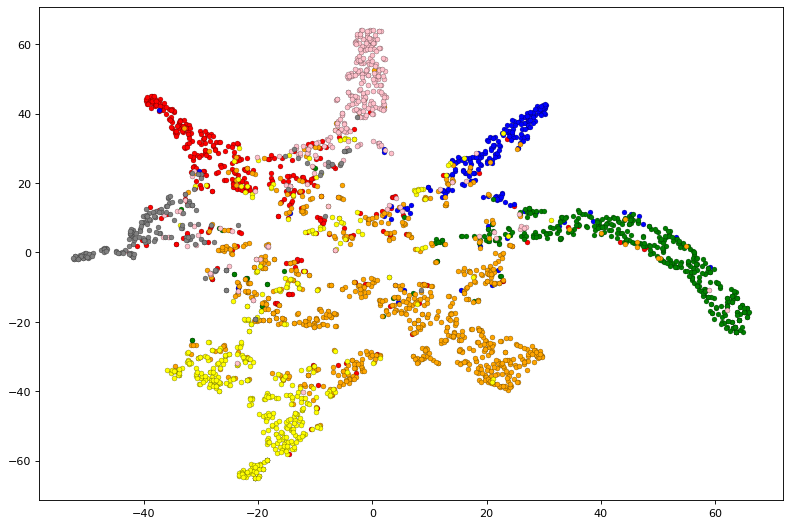

XGBoost with [5] hops has the following accuracies:
Train acc: 0.9785714285714285; Val acc 0.752; Test acc 0.739
The required training time was 6.89 s


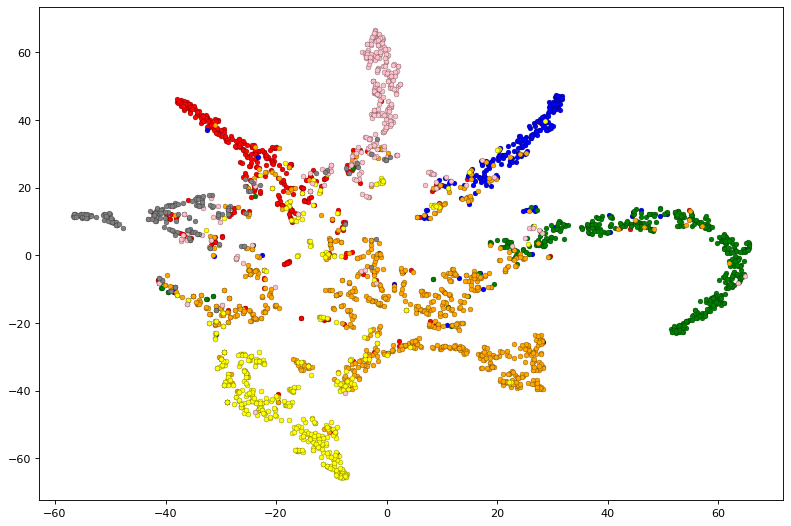

KeyboardInterrupt: 

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from torch.nn.functional import normalize
import torch 
def user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p = 2.0, dim = 1)
    
for hop in evaluated_hops:
    hops_list = [hop]
    
    clfs = [
        RandomForestClassifier(**hops_to_best_params[hops], random_state = 42,  n_jobs=10) for hops in hops_list
    ]
    framework = Framework([user_function for i in hops_list], 
                         hops_list=hops_list, ## to obtain best for local neighborhood
                         clfs=clfs,
                         gpu_idx=0,
                         handle_nan=0.0,
                        attention_configs=[None for i in hops_list])
    start = time.time()
    framework.fit(features,
                edge_index,
                y,
                train)
    train_time = time.time()-start
    
    y_pred_val = framework.predict(features,
                    edge_index,
                    val)
    y_pred_test = framework.predict(features,
                    edge_index,
                    test)
    y_pred_train = framework.predict(features,
                    edge_index,
                    train)
    y_pred_proba = framework.predict_proba(features, edge_index, torch.ones_like(y).type(torch.bool))
    val_score = accuracy_score(y[val], y_pred_val)
    test_score = accuracy_score(y[test], y_pred_test)
    train_score = accuracy_score(y[train], y_pred_train)
    print(f"XGBoost with {str(hops_list)} hops has the following accuracies:\nTrain acc: {str(train_score)}; Val acc {str(val_score)}; Test acc {str(test_score)}")
    print(f"The required training time was {str(round(train_time,2))} s")
    plot_tsne(y_pred_proba)